BIGRU SALES-BUSINESS

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import string
from sklearn.preprocessing import LabelEncoder

In [12]:
data = pd.read_csv('C:\Users\HP\Downloads\remya\project\dbsalesats.csv')

# Basic data inspection

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8002 entries, 0 to 8001
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           8002 non-null   int64 
 1   Resume_str   8002 non-null   object
 2   Category     8002 non-null   object
 3   title        8002 non-null   object
 4   description  8002 non-null   object
 5   ATS_Score    8002 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 375.2+ KB
None


        text_length   word_count
count   8002.000000  8002.000000
mean    5238.159835   683.960885
std     2243.299017   300.343104
min     1001.000000   128.000000
25%     3241.000000   443.000000
50%     5567.000000   717.000000
75%     6586.000000   863.000000
max    12763.000000  1644.000000


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


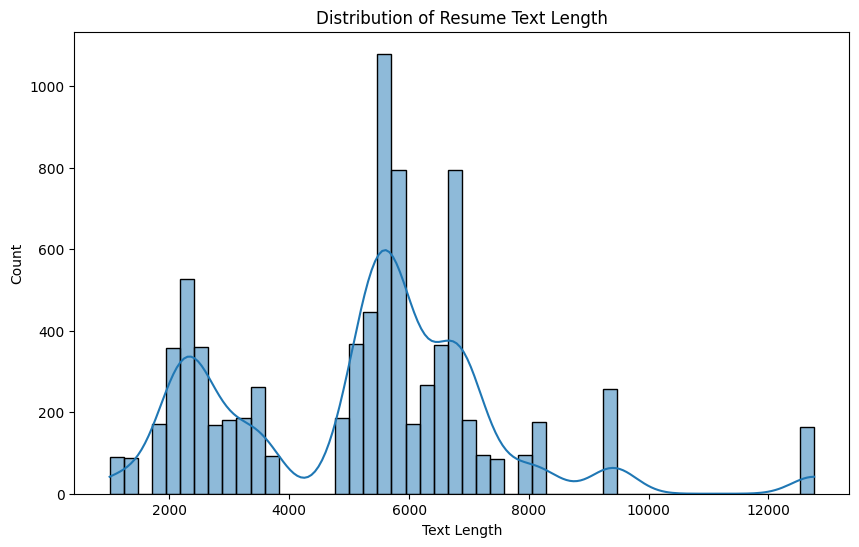

In [13]:

# Text Statistics
data['text_length'] = data['Resume_str'].apply(lambda x: len(str(x)))
data['word_count'] = data['Resume_str'].apply(lambda x: len(str(x).split()))
print(data[['text_length', 'word_count']].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Resume Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()



# Handle missing values if any
data.dropna(inplace=True)

# Encode categorical variables like 'Category'
encoder = LabelEncoder()
data['Category'] = encoder.fit_transform(data['Category'])

In [14]:
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the English model
nlp = spacy.load("en_core_web_sm")


# Abbreviations dictionary for job market
abbreviations = {
    "mgr": "manager",
    "sr": "senior",
    "jr": "junior",
    "asst": "assistant",
    "assoc": "associate",
    "dept": "department",
    "exp": "experience",
    "hr": "human resources",
    "acct": "account",
    "acctg": "accounting",
    "fin": "finance",
    "eng": "engineer",
    "engg": "engineering",
    "it": "information technology",
    "qa": "quality assurance",
    "dev": "development",
    "devops": "development operations",
    "proj": "project",
    "mktg": "marketing",
    "biz": "business",
    "comm": "communication",
    "adm": "administration",
    "sec": "secretary",
    "exec": "executive",
    "corp": "corporation",
    "intl": "international",
    "rep": "representative",
    "mfg": "manufacturing",
    "prod": "production",
    "purch": "purchasing",
    "sales": "sales",
    "cust": "customer",
    "svc": "service",
    "tech": "technical",
    "sup": "supervisor",
    "supv": "supervision",
    "log": "logistics",
    "inv": "inventory",
    "sch": "schedule",
    "edu": "education",
    "lang": "language",
    "pr": "public relations",
    "hrd": "human resources development",
    "cfo": "chief financial officer",
    "ceo": "chief executive officer",
    "coo": "chief operating officer",
    "cmo": "chief marketing officer",
    "cto": "chief technology officer",
    "cio": "chief information officer",
    "pmo": "project management office",
    "pmp": "project management professional",
    "ba": "business analyst",
    "bpm": "business process management",
    "ui": "user interface",
    "ux": "user experience",
    "svp": "senior vice president",
    "vp": "vice president",
    "gm": "general manager",
    "doe": "depends on experience",
    "r&d": "research and development",
    "seo": "search engine optimization",
    "sem": "search engine marketing",
    "smm": "social media marketing",
    "b2b": "business to business",
    "b2c": "business to consumer",
    "kpi": "key performance indicator",
    "roi": "return on investment",
    "saas": "software as a service",
    "paas": "platform as a service",
    "iaas": "infrastructure as a service",
    "crm": "customer relationship management",
    "erp": "enterprise resource planning",
    "sd": "software development",
    "pm": "project manager",
    "pa": "personal assistant",
    "exec": "executive",
    "fin": "finance",
    "hrm": "human resources management",
    "it": "information technology",
    "pr": "public relations",
    "qa": "quality assurance",
    "r&d": "research and development",
    "scm": "supply chain management",
    "seo": "search engine optimization",
    "smm": "social media marketing",
    "ux": "user experience",
    "ui": "user interface",
    "bi": "business intelligence",
    "dev": "development",
    "ops": "operations"
}


def expand_abbreviations(text, abbreviations):
    for abbr, expanded in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbr), expanded, text)
    return text

def clean_and_preprocess(text):
    text = expand_abbreviations(text, abbreviations)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    return nouns

# Apply cleaning and preprocessing
data['processed_resume'] = data['Resume_str'].apply(clean_and_preprocess)
data['processed_description'] = data['description'].apply(clean_and_preprocess)

# Extract nouns and combine processed text
data['nouns'] = data.apply(lambda row: extract_nouns(row['processed_resume'] + ' ' + row['processed_description']), axis=1)

# Ensure 'nouns' column is populated with lists
print(data['nouns'].head())

# Convert list of nouns to string
data['nouns_str'] = data['nouns'].apply(lambda x: ' '.join(x))

# Tokenizer and sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['nouns_str'])

nouns_sequences = tokenizer.texts_to_sequences(data['nouns_str'])
max_nouns_length = 10  # Adjust based on your data
nouns_data = pad_sequences(nouns_sequences, maxlen=max_nouns_length)

# Now you can use `nouns_data` in your model
print(nouns_data)
# Extract nouns and combine processed text

data['combined_text'] = data['processed_resume'] + ' ' + data['processed_description']
print(data['combined_text'].head())


0    [sale, summary, experience, material, handling...
1    [sale, career, overview, course, career, profe...
2    [sale, career, focus, sale, marketing, experti...
3    [sale, career, overview, course, career, profe...
4    [sale, associate, summary, time, position, tec...
Name: nouns, dtype: object
[[ 240  284  322 ...  151  296  121]
 [ 590  105    9 ...  279   22   17]
 [  68    1   25 ...   12    1  183]
 ...
 [  68    1   25 ...   12    1  183]
 [ 104  121  388 ...  565  187  349]
 [  14  827 2880 ...   82    3  109]]
0    sale summary adaptable extensive experience ma...
1    sale career overview course career professiona...
2    sale career focus sale marketing expertise inc...
3    sale career overview course career professiona...
4    sale associate summary actively seek time posi...
Name: combined_text, dtype: object


In [15]:
# Tokenize combined text
tokenizer.fit_on_texts(data['combined_text'].values.tolist())

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['combined_text'].values)
word_index = tokenizer.word_index

# Padding sequences
max_sequence_length = 1500
data_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Target variable
y = data['ATS_Score'].values

print(data_padded.shape)
print(y.shape)

(8002, 1500)
(8002,)


In [22]:
import pickle
with open('tokenizer_sales.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
data.to_csv(r'C:\Users\sachu\Desktop\DB\dbsalespreprocess.csv', index=False)

In [16]:
from sklearn.model_selection import train_test_split


# Split the data
# X_train_data, X_val_data, X_train_nouns, X_val_nouns, y_train, y_val = train_test_split(
#     data, nouns_data, labels, test_size=0.2, random_state=42
# )
X_train, X_test, X_train_nouns, X_test_nouns, y_train, y_test = train_test_split(data_padded, nouns_data,y, test_size=0.2, random_state=42)
X_train, X_val, X_train_nouns, X_val_nouns, y_train, y_val = train_test_split(X_train, X_train_nouns, y_train, test_size=0.2, random_state=42)
# Check shapes after splitting
print(f"X_train_data shape: {X_train.shape}")
print(f"X_train_nouns shape: {X_train_nouns.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_val_data shape: {X_val.shape}")
print(f"X_val_nouns shape: {X_val_nouns.shape}")
print(f"y_val shape: {y_val.shape}")

X_train_data shape: (5120, 1500)
X_train_nouns shape: (5120, 10)
y_train shape: (5120,)
X_val_data shape: (1281, 1500)
X_val_nouns shape: (1281, 10)
y_val shape: (1281,)


In [17]:
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, concatenate, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Model Inputs
text_input = Input(shape=(max_sequence_length,), name='text_input')
nouns_input = Input(shape=(10,), name='nouns_input')

# Embedding Layer
embedding_dim = 100  # Adjust based on your embedding size
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length)(text_input)

# Apply Spatial Dropout
embedded_dropout = SpatialDropout1D(0.2)(embedding_layer)

# Bidirectional GRU Layer
gru = Bidirectional(GRU(128, return_sequences=True, dropout=0.3))(embedded_dropout)

# Global Average Pooling
gru_pool = GlobalAveragePooling1D()(gru)

# Dense Layers for Nouns Input
nouns_dense = Dense(32, activation='relu')(nouns_input)

# Combine GRU output with nouns dense layer
combined = concatenate([gru_pool, nouns_dense])

# Additional Dense Layers with Regularization
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
output = Dense(1, activation='linear')(x)

# Model definition
model = Model(inputs=[text_input, nouns_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()


c:\Users\sachu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1500)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1500, 100) │    692,900 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 1500, 100) │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1500, 256) │    176,640 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nouns_input         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        352 │ nouns_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     18,496 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 890,501 (3.40 MB)

 Trainable params: 890,501 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# X_combined = np.concatenate([X_resume, X_description], axis=-1)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Define callbacks for early stopping, learning rate reduction, and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Training the modified model
history = model.fit(
    [X_train, X_train_nouns], y_train,
    epochs=10,  # Example value, can be adjusted
    batch_size=64,  # Example value, can be adjusted
    validation_data=([X_val, X_val_nouns], y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([X_test, X_test_nouns], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - loss: 9458.9238 - mae: 67.0268 - val_loss: 1069.0997 - val_mae: 28.9461 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - loss: 1534.0464 - mae: 31.9173 - val_loss: 658.8892 - val_mae: 21.9893 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - loss: 931.2355 - mae: 24.4498 - val_loss: 451.9830 - val_mae: 17.8879 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - loss: 753.5165 - mae: 21.9905 - val_loss: 424.2379 - val_mae: 17.4679 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - loss: 652.6080 - mae: 20.4742 - val_loss: 327.0625 - val_mae: 15.3357 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 412s 5s/step - loss: 566.9847 - mae: 19.1486 - val_loss: 340.0548 - val_mae: 15.7868 - learning_rate: 0.0010
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 407s 5s/step - loss: 508.0774 - mae: 17.8698 - val_loss: 352.3329 - val_mae: 

In [19]:
# Save the entire model to a file
model.save('bigrusales.keras')

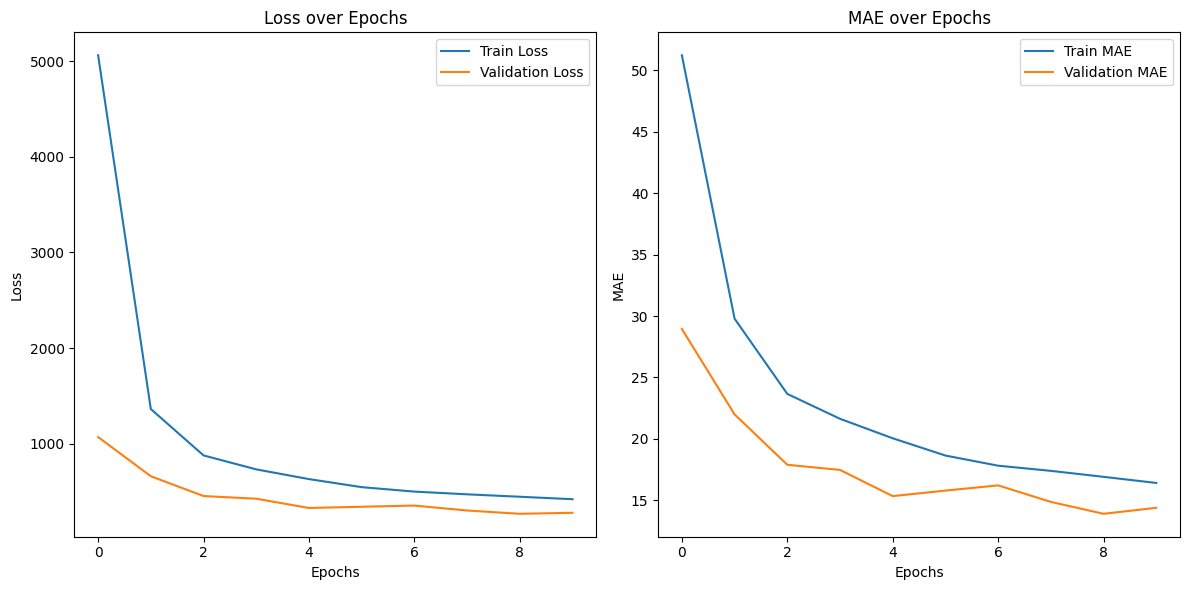

In [20]:
# Plot training history
import matplotlib.pyplot as plt


# Get history data from the History object
history_dict = history.history

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
